# Assignment 1 - DAX ESG dataset

## This notebook
This notebook is boiler plate code that can be re-used for loading the data.

## Interesting resources
- Source of the "actions" dataset: [Bridging the Gap in ESG Measurement: Using NLP to Quantify Environmental, Social, and Governance Communication](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=4622514)
- Source of the target "DAX ESG" dataset: [Detecting greenwashing signals through a comparison of ESG reports and public media](https://www.swisstext.org/wp-content/uploads/2023/09/Greenwashing.pdf )
- Example sentiment analysis on DAX ESG dataset https://colab.research.google.com/drive/1TrBuB3BbI5oOskD4ht7aHaAYyporTR7n?usp=sharing
- https://www.kaggle.com/datasets/equintel/dax-esg-media-dataset?resource=download

In [18]:
import pandas as pd

In [20]:
df = pd.read_pickle("DATA/esg_documents_for_dax_companies_with_scores_all.pkl")
df

,company,content,datatype,date,domain,esg_topics,internal,symbol,title,url,mean_action_score,n_chunks,n_estimated_actions
0,Beiersdorf AG,Sustainability Highlight Report CARE BEYOND SK...,sustainability_report,2021-03-31,NaN,"['CleanWater', 'GHGEmission', 'ProductLiabilit...",1,BEI,BeiersdorfAG Sustainability Report 2021,NaN,0.883412,25.0,22.0
1,Deutsche Telekom AG,Corporate Responsibility Report 2021 2 Content...,sustainability_report,2021-03-31,NaN,"['DataSecurity', 'Iso50001', 'GlobalWarming', ...",1,DTE,DeutscheTelekomAG Sustainability Report 2021,NaN,0.663768,263.0,173.0
2,Vonovia SE,VONOVIA SE SUSTAINABILITY REPORT 2021 =For a S...,sustainability_report,2021-03-31,NaN,"['Whistleblowing', 'DataSecurity', 'Vaccine', ...",1,VNA,VonoviaSE Sustainability Report 2021,NaN,0.429047,193.0,79.0
3,Merck KGaA,Sustainability Report 2021 TABLE OF CONTENTS S...,sustainability_report,2021-03-31,NaN,"['DataSecurity', 'DataMisuse', 'DrugResistance...",1,MRK,MerckKGaA Sustainability Report 2021,NaN,0.679299,210.0,142.0
4,MTU,Our ideas and concepts FOR A SUSTAINABLE FUTUR...,sustainability_report,2020-03-31,NaN,"['WorkLifeBalance', 'Corruption', 'AirQuality'...",1,MTX,MTUAeroEngines Sustainability Report 2020,NaN,0.682892,102.0,68.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
11543,Zalando SE,"To reset your pass, please enter your email be...",tech,2021-07-12,pocketgamer,"['CustomerService', 'Meat', 'HumanCapital', 'T...",0,ZAL,Pocket Gamer Connects Digital # 7,https://www.pocketgamer.biz/events/1636/pocket...,0.595652,13.0,8.0
11544,Zalando SE,Lo esencial: Materias primas: correlaciones e...,business,2022-07-05,marketscreener,['WasteManagement'],0,ZAL,"Índices: ni Value ni Growth, ¡defensivos!",https://es.marketscreener.com/noticias/ultimas...,0.000032,3.0,0.0
11545,Zalando SE,A look at the evolution of the fashion industr...,thinktank,2021-05-11,cbinsights,"['CustomerService', 'Recruiting', 'Sustainable...",0,ZAL,The Future of Fashion: Technology & the Industry,https://www.cbinsights.com/research/fashion-te...,0.996982,32.0,32.0
11546,Zalando SE,"By clicking submit, you agree to share your em...",tech,2022-05-23,techfundingnews,"['ClimateTech', 'Cybersecurity', 'CorporateCul...",0,ZAL,These are the top 10 EMEA VCs of 2022 — TFN,https://techfundingnews.com/these-are-the-top-...,0.470160,6.0,2.0


# 0. Cleaning the words from the content column

In [30]:
import numpy as np

# Focus on the rows with a score and content
df_1 = df[np.logical_and(
    np.logical_not(df['n_chunks'].isnull()),
    np.logical_not(df['content'].isnull())
)]

In [130]:
import spacy
import string
import matplotlib.pyplot as plt

nlp = spacy.load("en_core_web_md")
stop_words = spacy.lang.en.stop_words.STOP_WORDS
punctuations = string.punctuation


In [83]:
test_sentence = df_1['content'][0]

def spacy_tokenizer(sentence):
    mytokens = nlp(sentence.lower())
    mytokens = [word for word in mytokens if not word.is_oov and not word.is_stop and not word.is_punct]
    mytokens = [word.lemma_.strip() if word.lemma_ != "-PRON-" else word.lower_ for word in mytokens]
    mytokens = [word for word in mytokens if word not in stop_words and word not in punctuations]
    return mytokens

tokens = spacy_tokenizer(test_sentence)

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 342/342 [02:08<00:00,  2.66it/s]


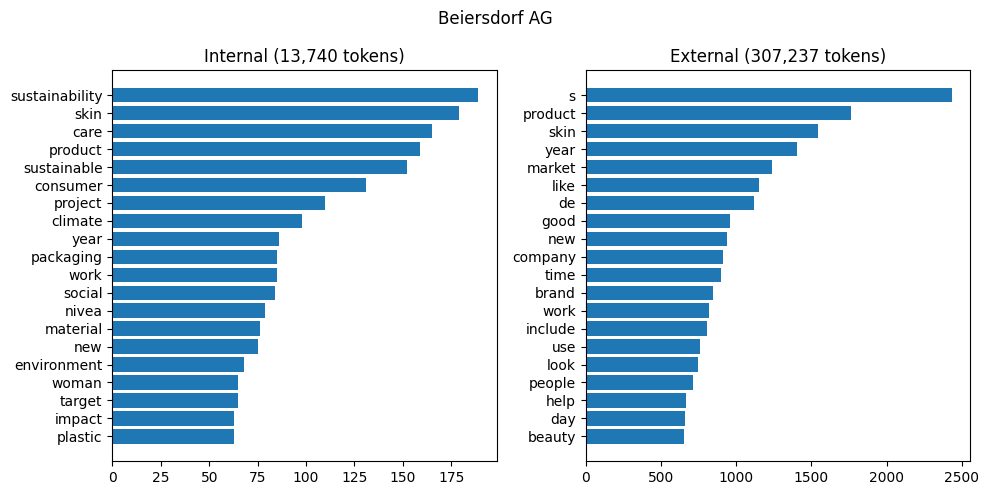

In [136]:
from collections import Counter
import tqdm
tqdm.tqdm.pandas()

def countWordFrequencies(example, counter):
    tokens = spacy_tokenizer(example)
    counter.update(tokens)

def frequency_df(df):
    counter = Counter()
    df['content'].progress_apply(lambda x: countWordFrequencies(x, counter))
    freq_df = pd.DataFrame.from_dict(counter, orient='index').reset_index()
    freq_df = freq_df.rename(columns={'index':'word', 0:'count'})
    freq_df = freq_df.sort_values(by='count', ascending=False)
    return freq_df

def compare_frequencies(df, company, save=False, top=20, directory='DATA/figures/'):
    df_1 = df[df['company'] == company]
    count_int = frequency_df(df_1[df_1['internal'] == 1])
    count_ext = frequency_df(df_1[df_1['internal'] == 0])
    fig, (ax1, ax2) = plt.subplots(1,2,figsize=(10, 5))
    ax1.barh(count_int['word'][:top][::-1], count_int['count'][:top][::-1])
    ax1.set_title('Internal ({:,.0f} tokens)'.format(count_int['count'].sum()))
    ax2.barh(count_ext['word'][:top][::-1], count_ext['count'][:top][::-1])
    ax2.set_title('External ({:,.0f} tokens)'.format(count_ext['count'].sum()))
    plt.suptitle(company)
    plt.tight_layout()
    if save:
        plt.savefig('{}{}_word_frequencies.png'.format(directory,company))
    plt.show()

compare_frequencies(df_1, 'Beiersdorf AG', save=True)

In [89]:
Beiersdorf_AG = df_1[df_1['company'] == 'Beiersdorf AG']

tokenFreqINT = Counter()
tokenFreqEXT = Counter()
countWordFrequenciesINT = lambda x: countWordFrequencies(x, tokenFreqINT)
countWordFrequenciesEXT = lambda x: countWordFrequencies(x, tokenFreqEXT)

Beiersdorf_AG[Beiersdorf_AG['internal'] == 1]['content'].progress_apply(countWordFrequenciesINT)
Beiersdorf_AG[Beiersdorf_AG['internal'] == 0]['content'].progress_apply(countWordFrequenciesEXT)

100%|██████████| 342/342 [02:14<00:00,  2.54it/s]


2584    None
2585    None
2586    None
2587    None
2588    None
        ... 
2921    None
2922    None
2923    None
2924    None
2925    None
Name: content, Length: 342, dtype: object

In [92]:
count_lemma_int = pd.DataFrame.from_dict(tokenFreqINT, orient='index').reset_index()
count_lemma_int.columns = ['lemma', 'count']
count_lemma_int.sort_values(by=['count'], ascending=False, inplace=True)
count_lemma_ext = pd.DataFrame.from_dict(tokenFreqEXT, orient='index').reset_index()
count_lemma_ext.columns = ['lemma', 'count']
count_lemma_ext.sort_values(by=['count'], ascending=False, inplace=True)

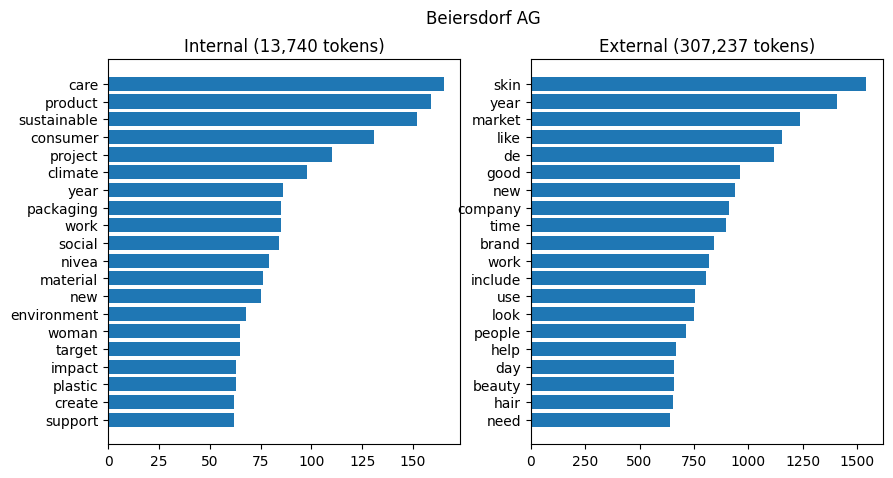

In [115]:
import matplotlib.pyplot as plt
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(10, 5))
ax1.barh(count_lemma_int['lemma'][2:22][::-1], count_lemma_int['count'][2:22][::-1])
ax1.set_title('Internal ({:,.0f} tokens)'.format(count_lemma_int['count'].sum()))
ax2.barh(count_lemma_ext['lemma'][2:22][::-1], count_lemma_ext['count'][2:22][::-1])
ax2.set_title('External ({:,.0f} tokens)'.format(count_lemma_ext['count'].sum()))
plt.suptitle('Beiersdorf AG')
plt.show()

In [112]:
df.company.unique()

array(['Beiersdorf AG', 'Deutsche Telekom AG', 'Vonovia SE', 'Merck KGaA',
       'MTU', 'E ONSE', 'RWE AG', 'Heidelberg Cement AG', 'Siemens AG',
       'Linde', 'Qiagen', 'Henkel', 'Daimler AG', 'Continental AG',
       'Bayer AG', 'Volkswagen AG', 'Fresenius', 'Symrise AG',
       'Sartorius AG', 'Porsche', 'SAP', 'Adidas AG', 'Deutsche Bank AG',
       'Puma SE', 'Siemens Healthineers AG', 'Airbus SE', 'Covestro AG',
       'Allianz SE', 'Infineon Technologies AG', 'BMW', 'Hannover R AG',
       'Siemens Energy', 'Zalando SE',
       'Muenchener Rueckversicherungs Gesellschaft AGin Muenchen',
       'Deutsche Post AG', 'BASF SE', 'Deutsche Boerse AG', 'Brenntag',
       'AkzoNobelNV', 'Vonovia'], dtype=object)

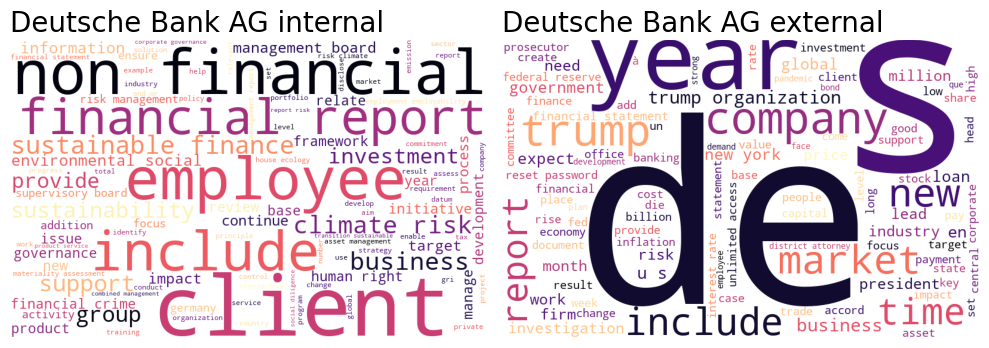

In [137]:
# inspired from https://medium.com/mlearning-ai/wordclouds-with-python-c287887acc8b

import numpy as np
from PIL import Image
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def add_wordcloud(text, company, ax, internal = True, random_state=42):
    wc = WordCloud(background_color='white', colormap = 'magma', max_words=100,
        stopwords = spacy_tokenizer(company), height = 500, width = 800, random_state=random_state
        ).generate(" ".join(spacy_tokenizer(text)))
    ax.axis("off")
    ax.imshow(wc)
    ax.set_title(
        f'{company} {"internal" if internal else "external"}',
        color='black',fontsize=20,loc='left')

def compare_wordclouds(data, company, save=False, random_state=42, directory='DATA/figures/'):
    df2 = data[data['company'] == company]
    df2int = df2[df2['internal'] == 1]
    df2ext = df2[df2['internal'] == 0]

    text_int = " ".join(df2int['content'].tolist())
    text_ext = " ".join(df2ext['content'].tolist())

    fig, (ax1, ax2) = plt.subplots(1,2,figsize=(10, 5))
    try:
        add_wordcloud(text_int, company, ax1, random_state=random_state)
    except:
        add_wordcloud(text_int[:900000], company, ax1, random_state=random_state)
    try:
        add_wordcloud(text_ext, company, ax2, internal = False, random_state=random_state)
    except:
        add_wordcloud(text_ext[:900000], company, ax2, internal = False, random_state=random_state)
    plt.tight_layout()
    if save:
        plt.savefig(f'{directory}wordcloud_{company}.png')
    plt.show()

compare_wordclouds(df_1, 'Deutsche Bank AG', save=True)
# https://www.forbes.com/sites/danalexander/2023/10/16/how-trump-fooled-deutsche-bank/
# >> Trump issue

In [155]:
df2 = df_1
df2int = df2[df2['internal'] == 1]
df2ext = df2[df2['internal'] == 0]

text_int = " ".join(df2int['esg_topics'].tolist())
text_ext = " ".join(df2ext['esg_topics'].tolist())

company=""
random_state=42
save=True
directory='DATA/figures/'

fig, (ax1, ax2) = plt.subplots(1,2,figsize=(10, 5))
try:
    add_wordcloud(text_int, company, ax1, random_state=random_state)
except:
    add_wordcloud(text_int[:900000], company, ax1, random_state=random_state)
try:
    add_wordcloud(text_ext, company, ax2, internal = False, random_state=random_state)
except:
    add_wordcloud(text_ext[:900000], company, ax2, internal = False, random_state=random_state)
plt.tight_layout()
if save:
    plt.savefig(f'{directory}wordcloud_esg_topics.png')
plt.show()

KeyboardInterrupt: 

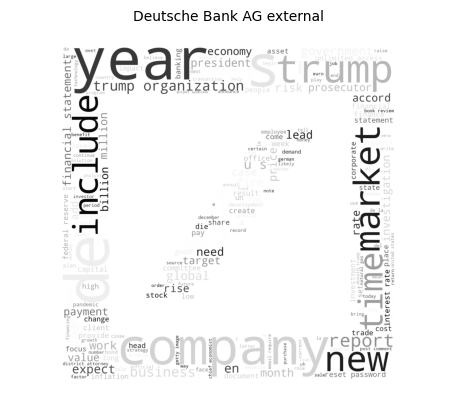

In [146]:
# DB_mask = np.array(Image.open("DATA/DB_logo.jpg"))

# wc = WordCloud(
#     background_color = 'white', mask = DB_mask, contour_width = 2, stopwords = spacy_tokenizer('Deutsche Bank AG'),
#     contour_color = 'white', colormap = 'Greys', width = 800, height = 500).generate(
#         " ".join(spacy_tokenizer(" ".join(df_1[np.logical_and(
#             df_1['company'] == 'Deutsche Bank AG',
#             df_1['internal'] == 0
#     )]['content'].to_list())[:900000])))
# plt.axis("off")
# plt.title('Deutsche Bank AG external', color='black',fontsize=10,loc='center')
# plt.imshow(wc)
# plt.savefig('DATA/figures/wordcloud_beautiful_external.png')
# plt.show()

In [3]:
from datasets import load_dataset

dataset = load_dataset("Emanuse/greenwashing_2")

c:\Users\User\Documents\VLERICK\NLP\vlerick-mai-nlp-2023\.env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Generating train split: 513 examples [00:00, 4331.09 examples/s]


In [11]:
gw_example = pd.DataFrame(dataset["train"])